# Import Libraries

In [150]:
%load_ext autoreload
%autoreload 2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS
import pickle
import os

# from simdata import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
# check for gpu

device = torch.device( "cuda" if torch.cuda.is_available() 
                      else "cpu")

print('Using device:', device)

Using device: cpu


In [152]:
# sol= np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)

temp = np.zeros((100, 100))


temp[:, 0] = 0
temp[:, -1] = 0
temp[0, :] = 1
a = 1
for i in range(1, 100):
    for j in range(1, 100):
        temp[i, j] = np.exp(-(1**2 * np.pi**2 * a * T[i,j]) / (1**2)) \
            * np.sin(1 * np.pi * X[i,j] / 1)




In [153]:
# Temperature dataset
temp_data = temp.flatten()

# input dataset- fdd
num_steps = 100
numpoints = 100 

pde_pts= 20000
ic_pts = 1000
bc_pts = 1000

x_c = 1
t_c = 1
temp_c = 1

input_x = X.flatten()
input_t = T.flatten()

input_data = np.stack((input_x,input_t),axis=1)

pde_x = np.linspace(0.1,0.9,pde_pts)
pde_t = np.linspace(0.1,0.9,pde_pts)
pde_data2 = np.stack((pde_x,pde_t),axis=1)

ic_x = np.linspace(0,1,ic_pts)
ic_t = np.zeros(ic_pts)
ic_data = np.stack((ic_x,ic_t),axis=1)

bc_x_l = np.zeros(bc_pts)
bc_t_l = np.linspace(0,1,bc_pts)
bc_data_l = np.stack((bc_x_l,bc_t_l),axis=1)

bc_x_r = np.ones(bc_pts)
bc_t_r = np.linspace(0,1,bc_pts)
bc_data_r = np.stack((bc_x_r,bc_t_r),axis=1)






In [154]:
input_t = torch.tensor(input_data).float().to(device)
inp_pdet = torch.tensor(pde_data2).float().to(device)
inp_ict = torch.tensor(ic_data).float().to(device)
inp_bclt = torch.tensor(bc_data_l).float().to(device)
inp_bclr = torch.tensor(bc_data_r).float().to(device)



temp_t = torch.tensor(temp_data).float().to(device)
temp_t = temp_t.view(-1,1)




In [155]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

print('Using device:', device)

Using device: cpu
Using device: cpu


# Fetch the data and models

In [156]:
job_id = 6835088
# Load the loss data from Output
file_path_tr = f"output_files/job_{job_id}/train-loss.pkl"

file_path_tt = f"output_files/job_{job_id}/test-loss.pkl"


In [157]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers):  # Constructor initializes the network
        super(PINN, self).__init__()  # Call the parent class (nn.Module) constructor
        layers = []  # Initialize an empty list to store the network layers

        # Input layer: Takes input features and maps them to the hidden layer size
        layers.append(nn.Linear(input_size, hidden_size))  # Add the first linear layer
        layers.append(nn.Tanh())  # Apply the activation function (Tanh)

        # Hidden layers: Create a series of hidden layers with activation functions
        for _ in range(hidden_layers):  # Loop for creating multiple hidden layers
            layers.append(nn.Linear(hidden_size, hidden_size))  # Add a hidden linear layer
            layers.append(nn.Tanh())  # Add an activation function (Tanh)

        # Output layer: Maps the final hidden layer outputs to the desired output size
        layers.append(nn.Linear(hidden_size, output_size))  # Add the final linear layer
        self.base = nn.Sequential(*layers)  # Create a sequential container with all layers
        self._init_weights()  # Initialize the network weights  

    def _init_weights(self):
        for layer in self.base:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x, t):  # Define the forward pass of the network
        input_features = torch.cat([x, t], dim=1)  # Concatenate input tensors along dimension 1
        m = self.base(input_features)  # Pass the concatenated input through the network
        return m  # Return the network output

In [158]:

import io
# Load train and test losses
# train_loss = load_pickle(file_path_tr)
# with open(file_path_tr, 'rb') as f:
#     train_loss = pickle.load(f)

with open(file_path_tr, 'rb') as f:
    train_loss = pickle.load(f)

with open(file_path_tt, 'rb') as f:
    test_loss = pickle.load(f)

loss_train = train_loss
loss_test = test_loss
# print(f"Train loss loaded on {device}: {type(train_loss)}")
# print(f"Test loss loaded on {device}: {type(test_loss)}")

# Load the Trained Model
model = PINN(2, 20, 1, 5).to(device)
model_location = f"output_files/job_{job_id}/best-model.pth"
model.load_state_dict(torch.load(model_location, map_location =device,weights_only=False))




<All keys matched successfully>

# visualise train test Loss

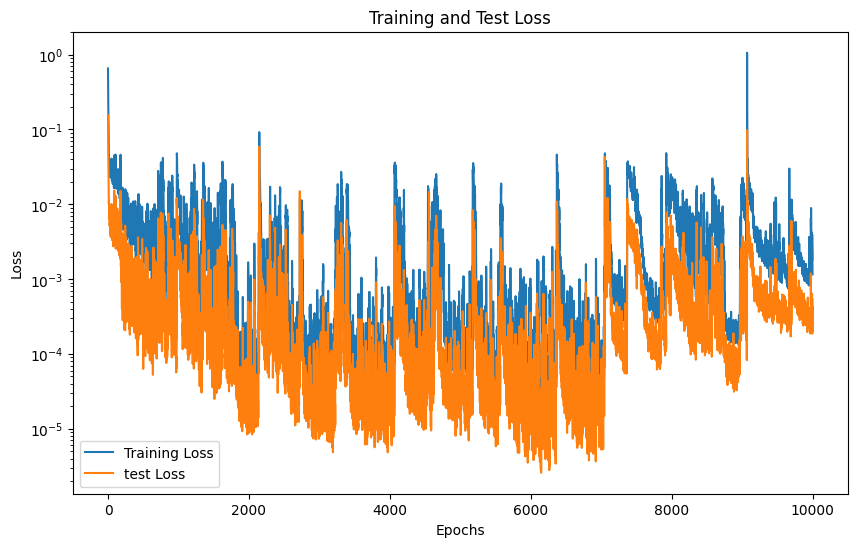

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(loss_train["train-loss"], label='Training Loss')
plt.plot(loss_test["test-loss"], label='test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Visualise PDE losses

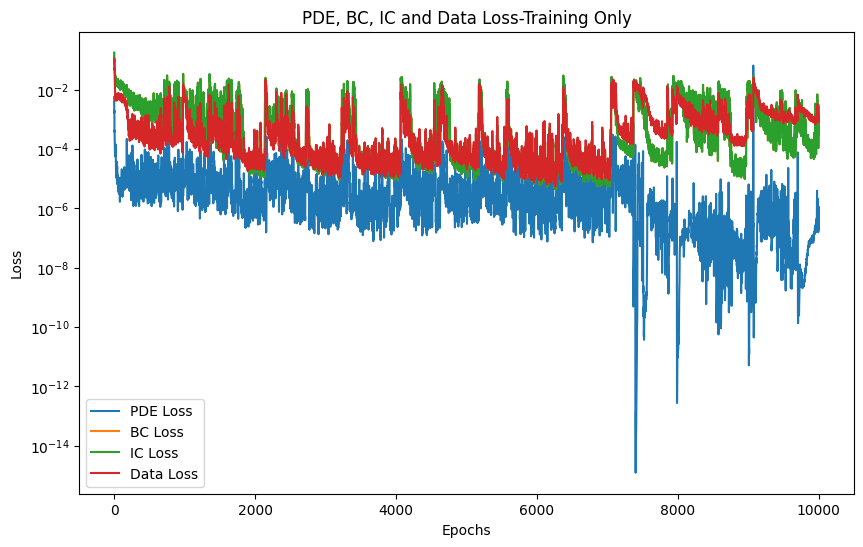

In [160]:
pde_losses = np.array(loss_train["pde-loss"])
bc_losses = np.array(loss_train["bc-loss"])
ic_losses = np.array(loss_train["bc-loss"])

data_losses = np.array(loss_train["data-loss"])

plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE Loss')
plt.plot(bc_losses, label='BC Loss')
plt.plot(ic_losses, label='IC Loss')
plt.plot(data_losses, label='Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('PDE, BC, IC and Data Loss-Training Only')
plt.legend()
plt.show()



# Visualise results at the left, right and centre

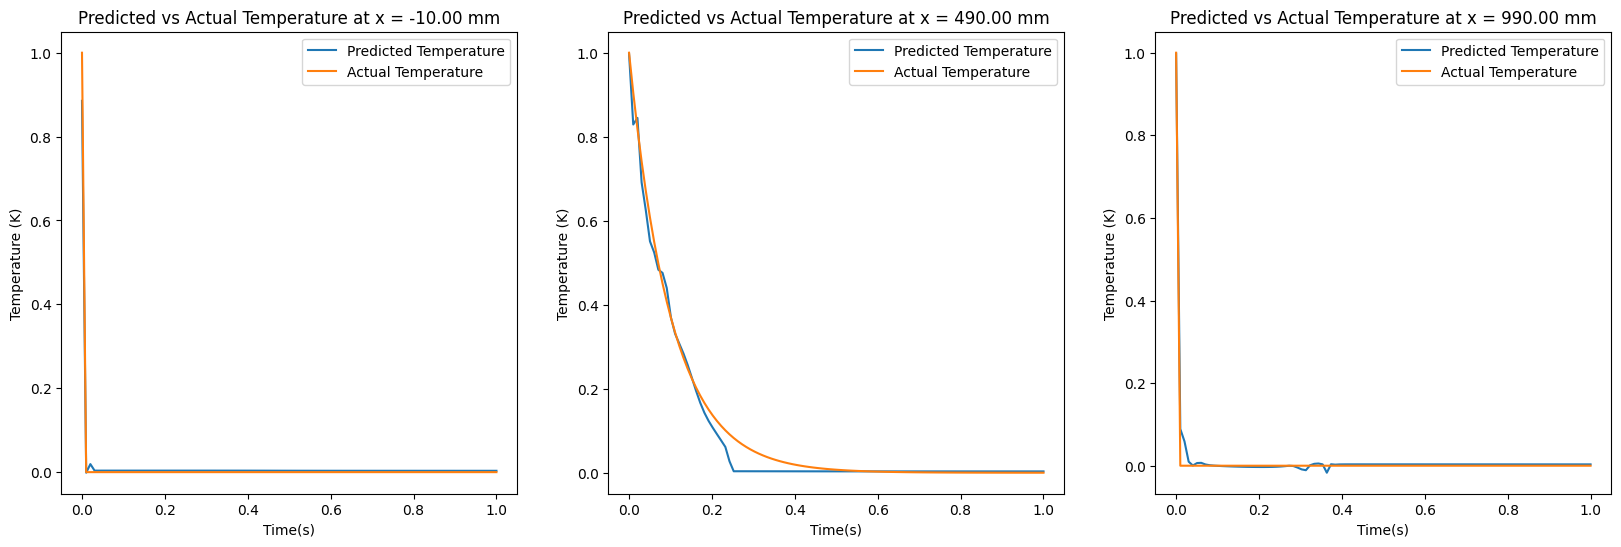

In [161]:
inp_data = input_t
# inp_data = torch.tensor(input_t).float().to(device) # Convert the inputs to a tensor

# load model saved

temp_nn = model(inp_data[:,0].unsqueeze(1), inp_data[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model

dx = 1/100
time_end = 1
# temp_nn = invscaler(temp_nn,500.0,919.0) # Inverse transform the predictions
temp_d= temp_data.reshape(num_steps, numpoints) # Reshape the actual temperature data to a 2D array
temp_nn_t = temp_nn.reshape(num_steps, numpoints) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, time_end, num_steps )
left , idx, right = 0, 50, 100

fig = plt.figure(figsize=(20, 6))
ax1,ax2,ax3 = fig.subplots(1,3)
ax1.plot(time_ss, temp_nn_t[:,left], label='Predicted Temperature')
ax1.plot(time_ss, temp_d[:,left], label='Actual Temperature') 
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title(f'Predicted vs Actual Temperature at x = {(left-1)*dx*1000:.2f} mm')
ax1.legend()

ax2.plot(time_ss, temp_nn_t[:,idx-1], label='Predicted Temperature')
ax2.plot(time_ss, temp_d[:,idx-1], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title(f'Predicted vs Actual Temperature at x = {(idx-1)*dx*1000:.2f} mm')
ax2.legend()

ax3.plot(time_ss, temp_nn_t[:,right-1], label='Predicted Temperature')
ax3.plot(time_ss, temp_d[:,right-1], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title(f'Predicted vs Actual Temperature at x = {(right-1)*dx*1000:.2f} mm')
ax3.legend()
plt.show()



# Visualsie IC field

Text(0.5, 1.0, 'Predicted Temperature Distribution along initial condition')

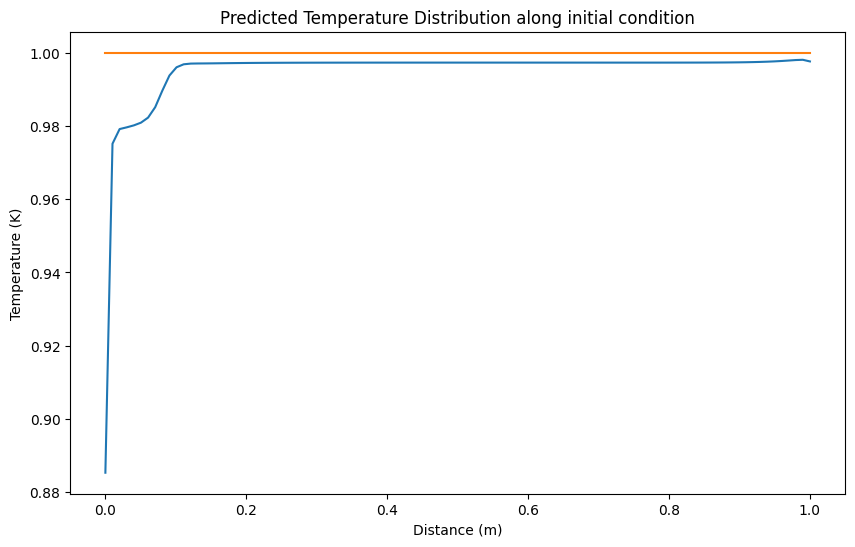

In [162]:
x = np.linspace(0, 1, 100)
t = np.zeros_like(x)

x = torch.tensor(x).float().to(device)
t = torch.tensor(t).float().to(device)
temp_pred = model(x.unsqueeze(1), t.unsqueeze(1)).cpu().detach().numpy()

Act_temp = (torch.ones_like(x)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x.cpu().detach().numpy(), temp_pred, label='Predicted Temperature')
plt.plot(x.cpu().detach().numpy(), Act_temp, label='Actual Temperature')
plt.xlabel('Distance (m)')
plt.ylabel('Temperature (K)')
plt.title('Predicted Temperature Distribution along initial condition')
#end


# Visualise Field of the results

(100, 100)
(100, 100)


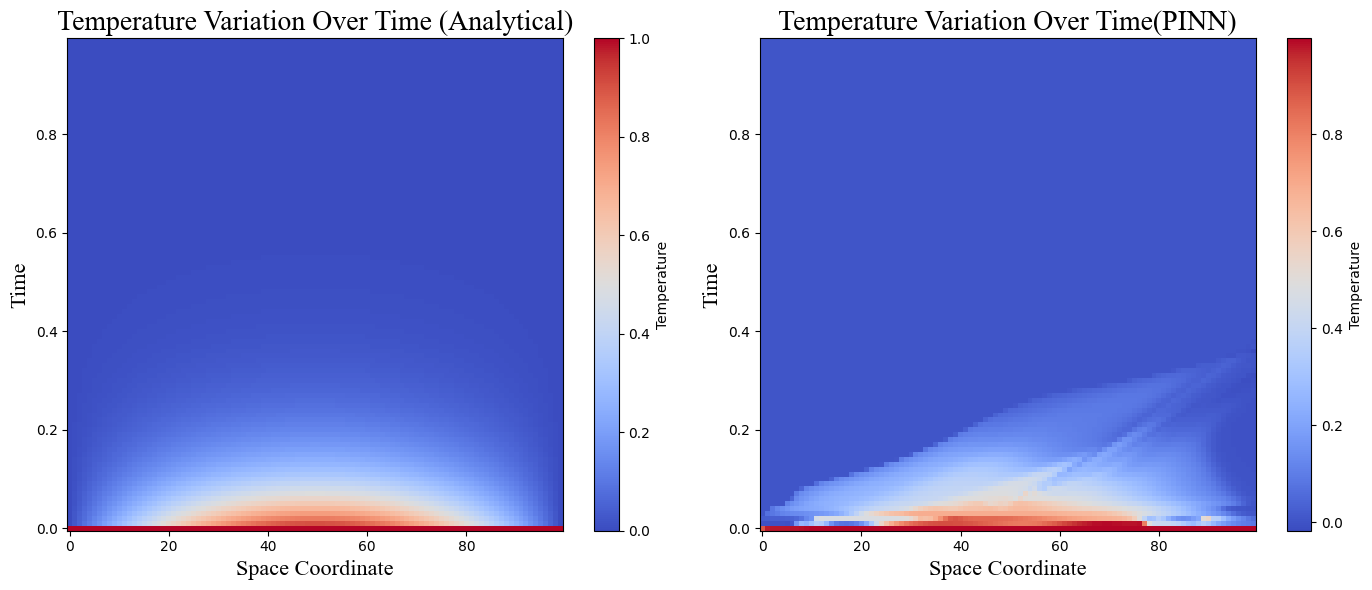

In [163]:


Act_temp = temp_data
Act_temp = Act_temp.reshape(num_steps, numpoints)
print(Act_temp.shape)

input_pred = input_t
temp_nn = model(input_pred[:,0].unsqueeze(1), input_pred[:,1].unsqueeze(1)).cpu().detach().numpy()
temp_nn = temp_nn 
temp_nn = temp_nn.reshape(num_steps, numpoints)

print(temp_nn.shape)
dt = 1/100
space_coord, time_coord = np.meshgrid(np.arange(Act_temp.shape[1]), np.arange(Act_temp.shape[0]))
time_coord = time_coord * dt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))



# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, Act_temp, cmap='coolwarm')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time (Analytical)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im1, ax=ax1, label='Temperature')

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='coolwarm')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(PINN)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im2, ax=ax2, label='Temperature')

plt.tight_layout()

plt.show()

